In [238]:
import pandas as pd
all4on=pd.read_excel("Scenario2_LR+SR.xlsx")
# all4on.to_csv("2.csv",index=False)
all4on['aggregate']=all4on['aggregate']*900
# all4on

In [239]:
# from sklearn.preprocessing import StandardScaler
# standard_scale = StandardScaler() 
# all4on[["aggregate"]]=standard_scale.fit_transform(all4on[["aggregate"]])
all4on.to_csv("2.csv",index=False)

In [240]:
sig_db=pd.read_csv("AC_signature_database.csv")

sig_db.fillna(sig_db.mean(),inplace=True)
# sig_db


In [241]:
# from sklearn.preprocessing import StandardScaler
# standard_scale = StandardScaler() 
# sig_db['LivingRmAC'] = standard_scale.fit_transform(sig_db[['LivingRmAC']])
# sig_db['MasterRmAC'] = standard_scale.fit_transform(sig_db[['MasterRmAC']])
# sig_db['StudyRmAC'] = standard_scale.fit_transform(sig_db[['StudyRmAC']])
# sig_db['GuestRmAC'] = standard_scale.fit_transform(sig_db[['GuestRmAC']])

sig_db.to_csv("1.csv",index=False)
# sig_db

In [242]:
sig_db['LivingRmAC'] = sig_db[['LivingRmAC']]*900
sig_db['MasterRmAC'] = sig_db[['MasterRmAC']]*900
sig_db['StudyRmAC'] = sig_db[['StudyRmAC']]*900
sig_db['GuestRmAC'] = sig_db[['GuestRmAC']]*900

sig_db.to_csv("1.csv",index=False)
# sig_db

1 of 6> reading data
2 of 6> pair clusters appliance wise
3 of 6> generates full power series of appliances
4 of 6> checking appliance power signatures matches
        > found 4 appliances. Verifying signature matching
5 of 6> creating appliance power timeseries
10312.7 120438.0 608.8 18001.0
6 of 6> plotting the input and results :)


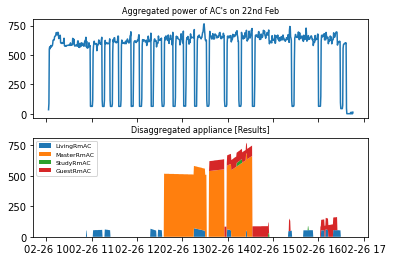

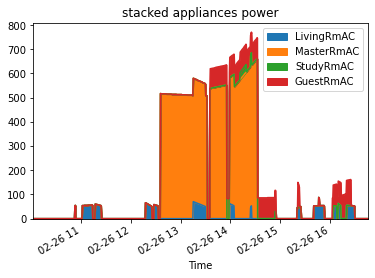

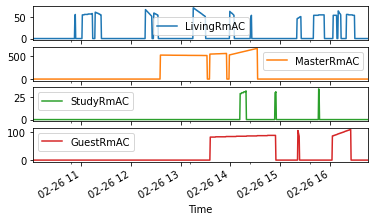

In [243]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
This implements GSP energy disaggregation method proposed in the paper "On a training-less solution for non-intrusive appliance load monitoring using graph signal processing"

Created on Thu Feb  1 15:42:41 2018

"""
from __future__ import division
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import gsp_support as gsp
import matplotlib.pyplot as plt

#%%
print("1 of 6> reading data")
csvfileaggr = "./2.csv"
csvfiledisaggr = "./output_disaggr_AC.csv"
df = pd.read_csv(csvfileaggr, index_col = "Time") # read demo file with aggregated active power
df.index = pd.to_datetime(df.index)
#dfd = pd.read_csv(csvfiledisaggr, index_col = "Time") # read file with ground truth disaggregated appliances
#dfd.index = pd.to_datetime(dfd.index)

# select date range
start_date = '2021-02-26 10:02:15.557' # from 2021-02-22 16:21
end_date = '2021-02-26 16:46:26.253' # to 2021-02-22 17:30
mask = (df.index > start_date) & (df.index < end_date)
df = df.loc[mask]
#mask = (dfd.index > start_date) & (dfd.index < end_date)
#dfd = dfd.loc[mask]
# print(df)
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(df)
axs[0].set_title("Aggregated power of AC's on 22nd Feb", size=8)
#axs[1].stackplot(dfd.index, dfd.values.T, labels = list(dfd.columns.values))
#axs[1].set_title("Disaggregated appliance power [Ground Truth]", size=8)
#axs[1].legend(loc='upper left', fontsize=6)

# Please read the paper to undertand following parameters. Note initial values of these parameters depends on the appliances used and the frequency of usage.
sigma = 20 #0.5; #originally 10
ri = 0.15 #0.15 #variance i think?
T_Positive = 20 #0.1; #changed from 20
T_Negative = -20  #-0.1 #changed from -20
#Following parameters alpha and beta are used in Equation 15 of the paper 
# alpha define weight given to magnitude and beta define weight given to time - alpha+beta=1
alpha =  0.5
beta  = 0.5
# this defines the  minimum number of times an appliance is set ON in considered time duration
instancelimit =3  #1 # change this if the results show the incorrect number of appliances being matched-changed from 10

#%% 
main_val = df.values # get only readings
main_ind = df.index  # get only timestamp
data_vec =  main_val
signature_database = "1.csv" #the signatures were extracted of power analysis from Feb 22nd
threshold =  2000 #1 # threshold of DTW algorithm used for appliance power signature matching

delta_p = [round(data_vec[i+1][0] - data_vec[i][0], 2) for i in range(0, len(data_vec) - 1)]
event =  [i for i in range(0, len(delta_p)) if (delta_p[i] > T_Positive or delta_p[i] < T_Negative) ]

# initial and refined clustering block of Figure 1 in the paper
clusters = gsp.refined_clustering_block(event, delta_p, sigma, ri)
# print(clusters)
# Feature matching block of Figure 1 in the paper
finalclusters, pairs = gsp.pair_clusters_appliance_wise(clusters, data_vec, delta_p, instancelimit)
appliance_pairs = gsp.feature_matching_module(pairs, delta_p, finalclusters, alpha, beta)
# print(finalclusters)
# print(appliance_pairs)

# create appliance wise disaggregated series
power_series, appliance_signatures = gsp.generate_appliance_powerseries(appliance_pairs, delta_p)
# print(power_series)
# label the disaggregated appliance clusters by comparing with signature DB
labeled_appliances = gsp.label_appliances(appliance_signatures, signature_database, threshold)
# print(labeled_appliances)
# Attach timestamps to generated series
power_timeseries = gsp.create_appliance_timeseries(power_series, main_ind)
# print(power_timeseries)
# create pandas dataframe of all series
gsp_result = pd.concat(power_timeseries, axis = 1)
# gsp_result=gsp_result*1000
# print(gsp_result)
print(gsp_result[gsp_result.columns[0]].sum(),gsp_result[gsp_result.columns[1]].sum(),gsp_result[gsp_result.columns[2]].sum(),gsp_result[gsp_result.columns[3]].sum())
# labels= [i[1] for i in list(labeled_appliances.items())]
labels=['LivingRmAC','MasterRmAC','StudyRmAC','GuestRmAC']
#gsp_result.drop(columns=[3,4])
#gsp_result.plot()
#gsp_result.columns=labels
#plt.plot(gsp_result, labels=gsp_result.columns)
# print(labels)
#AXS CHANGES FROM 2 TO 1\
# print(gsp_result.values.T)
axs[1].stackplot(gsp_result.index, gsp_result.values.T, labels=labels)
axs[1].set_title("Disaggregated appliance [Results]", size=8)
axs[1].legend(loc='upper left', fontsize=6)
gsp_result.columns=['LivingRmAC','MasterRmAC','StudyRmAC','GuestRmAC']
gsp_result.plot(kind='area', stacked=True, title='stacked appliances power', label=labeled_appliances)
gsp_result.plot(subplots=True, layout=(5,1))
print("6 of 6> plotting the input and results :)")
# print(gsp_result)
plt.show()

#gsp.calculate_energy_pct(dfd, gsp_result)

# gsp_result.to_csv("AC_disagg.csv")
